In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
import re
from venn import venn
from scipy.stats import pearsonr, spearmanr, ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

# load data

In [3]:
ic50 = pd.read_csv(
    "../data/drug/ic50_processed.csv")

meta = pd.read_csv("../data/E0022_P06_final_sample_map.txt", sep='\t')
tissue_types = meta[['Cell_line', 'Tissue_type']].drop_duplicates()
# protein_raw = pd.read_csv("../data/protein/E0022_P06_log_transformed.tsv", sep='\t')
protein_raw_median = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_RawMedian_no_control.txt", sep='\t')
protein_median = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_Median_no_control.txt", sep='\t')
protein_RUV = pd.read_csv("../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control.txt", sep='\t')

In [4]:
df_broad = pd.read_csv('../data/ccle/protein_quant_current_normalized.csv')
df_broad = df_broad.drop(
    ['Protein_Id', 'Gene_Symbol', 'Description', 'Group_ID', 'Uniprot_Acc'],
    axis=1).rename(columns={
        'Uniprot': 'Protein'
    }).set_index('Protein')
df_broad = df_broad.drop([
    'SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02',
    'HCT15_LARGE_INTESTINE_TenPx30'
],
                         axis=1)
rename_dict = {}
for x in df_broad.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
df_broad = df_broad.rename(columns=rename_dict)
df_broad = df_broad.drop(
    [x for x in df_broad.columns.tolist() if 'TenPx' in x],
    axis=1).transpose()

curr_dict = meta[['CCLE_ID','Cell_line']].drop_duplicates().set_index('CCLE_ID').to_dict()['Cell_line']
df_broad.index = df_broad.index.map(curr_dict)

common_lines_broad = [x for x in df_broad.index.tolist() if x in protein_RUV['Cell_line'].values]
print('Number of common cell lines: ',len(common_lines_broad))

len(set(common_lines_broad))
df_broad.index.name = 'Cell_line'
ccle_protein = df_broad.reset_index()

Number of common cell lines:  295


# correlations

## raw_median normalised

In [357]:
protein_sanger = protein_raw_median
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_cell_lines)

295

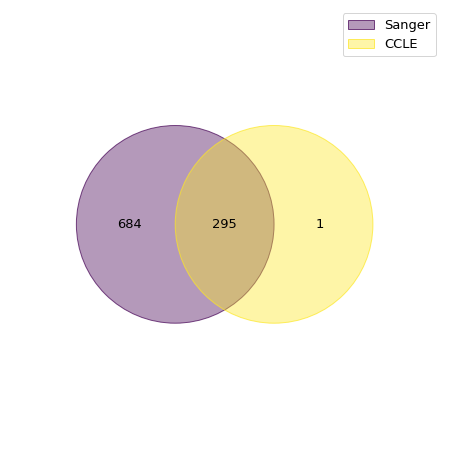

In [358]:
venn(cell_line_dict)

In [359]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [360]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [361]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [362]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4177725812875462, pvalue=0.0)

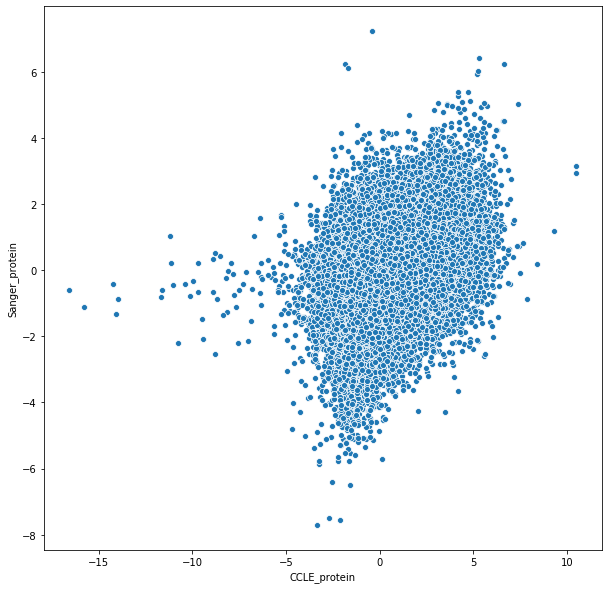

In [264]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

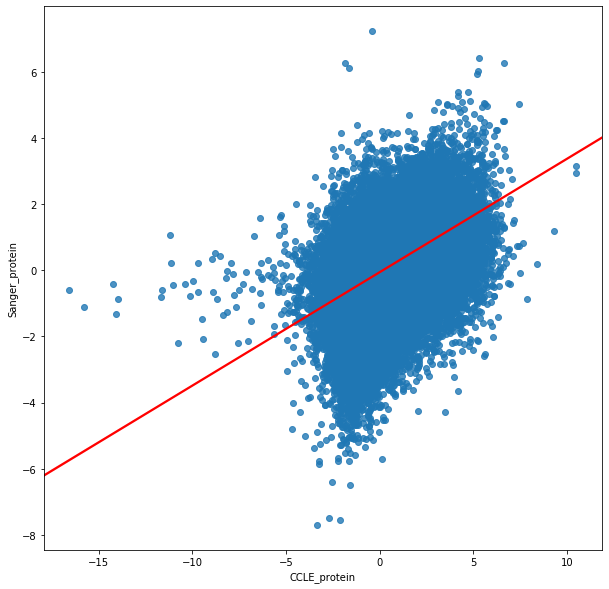

In [265]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [363]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]

# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [364]:
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [365]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [366]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [367]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4275')

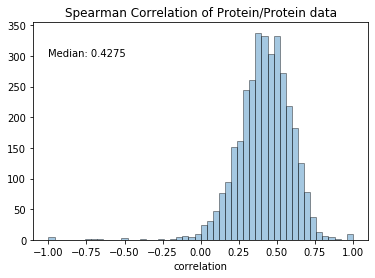

In [368]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## median

In [42]:
protein_sanger = protein_median
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2966

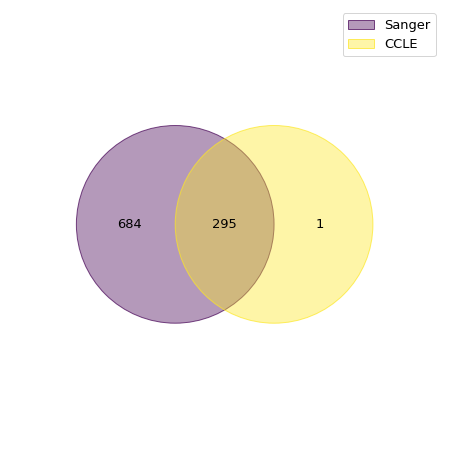

In [43]:
venn(cell_line_dict)

In [44]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [45]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [46]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [47]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4341765319466016, pvalue=0.0)

Text(-15, 6, 'Spearman R: 0.4342')

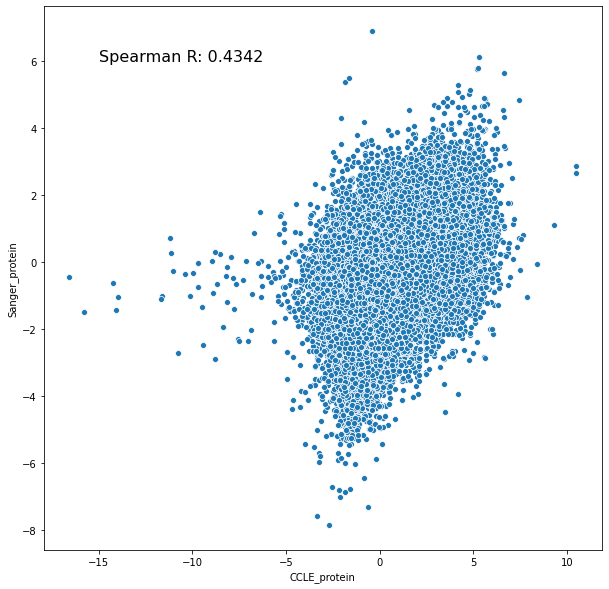

In [48]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)
plt.text(-15, 6,
         f"Spearman R: {spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])[0]:.4f}",fontsize=16)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [350]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [352]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [353]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [354]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [355]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4542')

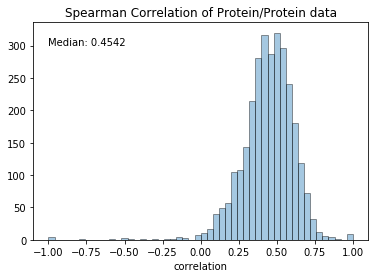

In [356]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## RUV

In [37]:
protein_sanger = protein_RUV
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

3238

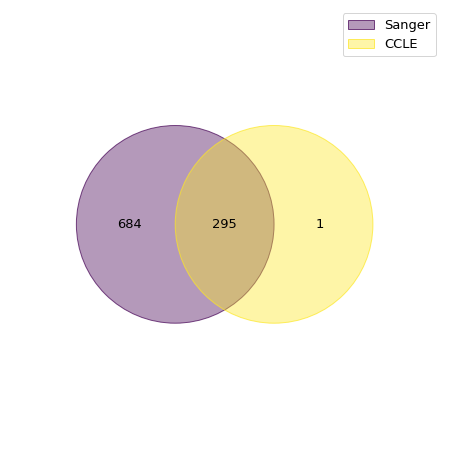

In [33]:
venn(cell_line_dict)

In [34]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [35]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [36]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [37]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.412831729793433, pvalue=0.0)

Text(-15, 6, 'Spearman R: 0.4128')

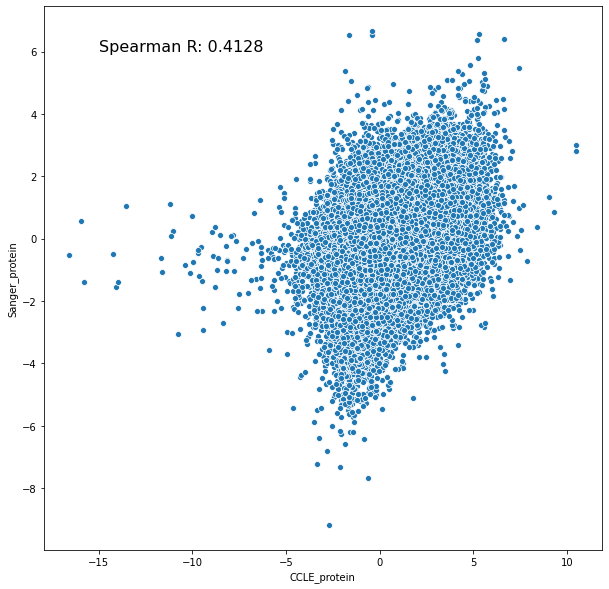

In [41]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)
plt.text(-15, 6,
         f"Spearman R: {spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])[0]:.4f}",fontsize=16)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [18]:
ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)].to_csv(
    "../data/ccle/protein_matrix_common_all_proteins.tsv", index=False, sep='\t')

In [14]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
ccle_protein_common.to_csv("../data/ccle/protein_matrix_common_ruv.tsv", index=False, sep='\t')

In [15]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

protein_sanger_common.to_csv("../data/protein/P06_matrix_common_ccle_ruv.tsv",
                                 index=False,
                                 sep='\t')

In [381]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [382]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [383]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-0.9999999999999999, 300, 'Median: 0.4287')

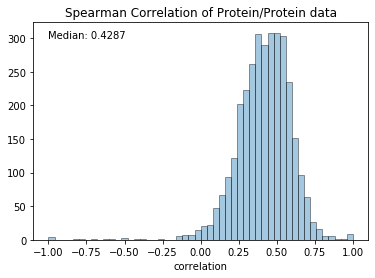

In [384]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

## RUV vs median common

### median

In [385]:
protein_sanger = protein_median[median_ruv_common]
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2935

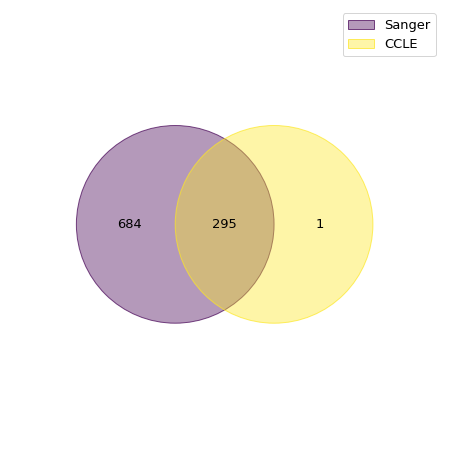

In [386]:
venn(cell_line_dict)

In [387]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [388]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [389]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [390]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4353661349000104, pvalue=0.0)

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [391]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [392]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [393]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [394]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [395]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-1.0, 300, 'Median: 0.4561')

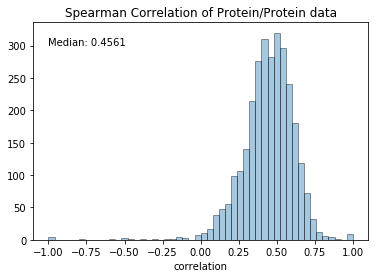

In [396]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

### RUV

In [397]:
protein_sanger = protein_RUV[median_ruv_common]
cell_line_dict = {"Sanger":set(protein_sanger['Cell_line'].unique()),
                 "CCLE":set(ccle_protein['Cell_line'].unique())}

common_cell_lines = list(
    set(protein_sanger['Cell_line'].unique()).intersection(
        set(ccle_protein['Cell_line'].unique())))

common_proteins = list(
    set(protein_sanger.drop(['Cell_line'], axis=1).columns).intersection(
        set(ccle_protein.drop(['Cell_line'], axis=1).columns)))

len(common_proteins)

2935

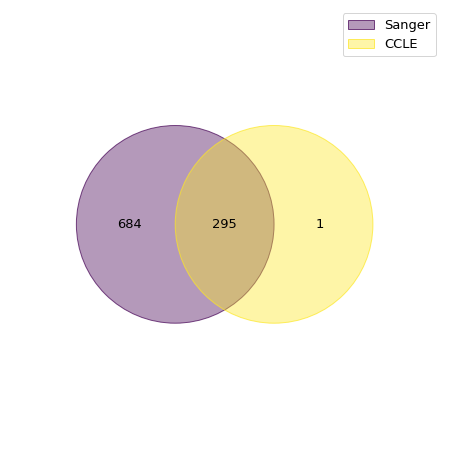

In [398]:
venn(cell_line_dict)

In [399]:
ccle_protein_melt = pd.melt(ccle_protein, id_vars='Cell_line', value_name='CCLE_protein', var_name='protein')

In [400]:
sanger_protein_melt = pd.melt(protein_sanger,
                              id_vars='Cell_line',
                              value_name='Sanger_protein',
                              var_name='protein')

In [401]:
combined = pd.merge(ccle_protein_melt, sanger_protein_melt, on=['Cell_line', 'protein'])

combined = combined.dropna()

combined = pd.merge(combined, tissue_types)

In [402]:
spearmanr(combined['CCLE_protein'], combined['Sanger_protein'])

SpearmanrResult(correlation=0.4193009295880735, pvalue=0.0)

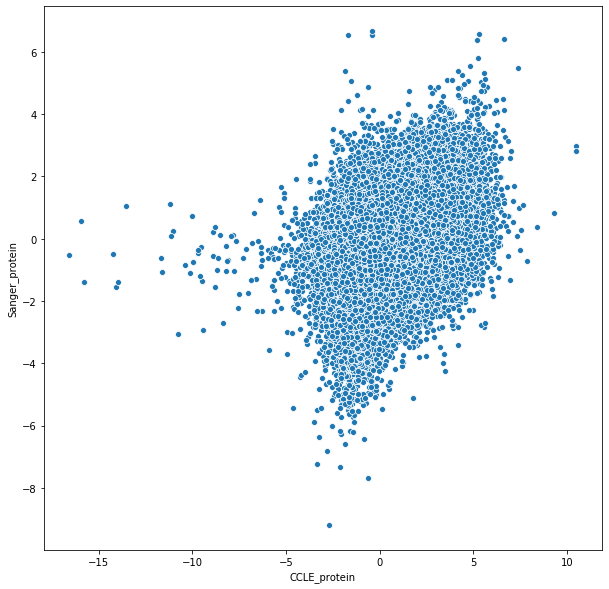

In [403]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='CCLE_protein',
                y='Sanger_protein',
                data=combined)

In [ ]:
plt.figure(figsize=(10, 10))
sns.regplot('CCLE_protein', 'Sanger_protein', combined,
            line_kws={'color': 'red'})

In [404]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)]
ccle_protein_common = pd.concat([ccle_protein_common['Cell_line'], ccle_protein_common[common_proteins]], axis=1)
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])
ccle_protein_common = ccle_protein_common.loc[:,~ccle_protein_common.columns.duplicated()]
# ccle_protein_common.to_csv("../data/ccle/protein_matrix_common.tsv", index=False, sep='\t')

In [405]:
protein_sanger_common = protein_sanger[common_proteins]
protein_sanger_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]
protein_sanger_common = pd.concat([
    protein_sanger_common['Cell_line'],
    protein_sanger_common[common_proteins]
],
                                      axis=1)

# protein_sanger_common.to_csv("../data/protein/P06_matrix_common.tsv",
#                                  index=False,
#                                  sep='\t')

In [406]:
ccle_protein_common = ccle_protein_common[ccle_protein_common['Cell_line'].isin(
    common_cell_lines)].drop_duplicates('Cell_line')
sanger_protein_common = protein_sanger[
    protein_sanger['Cell_line'].isin(common_cell_lines)]

In [407]:
ccle_protein_common = ccle_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)
sanger_protein_common = sanger_protein_common.sort_values(
    by=['Cell_line']).reset_index(drop=True)

In [408]:
corr_dict = {}
for protein in common_proteins:
    tmp_df_dict = {}
    tmp_df_dict['sanger'] = list(sanger_protein_common[protein].values)
    tmp_df_dict['ccle'] = list(ccle_protein_common[protein].values)
    tmp_df = pd.DataFrame(tmp_df_dict)
    tmp_df = tmp_df.dropna()
    corr = spearmanr(tmp_df['sanger'].values,
                                   tmp_df['ccle'].values)[0]
    if not np.isnan(corr):
        corr_dict[protein] = corr

Text(-0.9999999999999999, 300, 'Median: 0.4381')

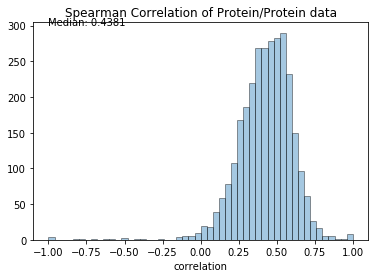

In [409]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of Protein/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 300,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

# model comparison

## min 300

In [203]:
ccle_score = pd.read_csv("../work_dirs/vs_ccle/RandomForest/scores_202004121231_ccle_common_zero_300.csv")
ccle_score_all = pd.read_csv("../work_dirs/vs_ccle/RandomForest/scores_202004121231_ccle_all_zero_300.csv")
sanger_score = pd.read_csv("../work_dirs/vs_ccle/RandomForest/scores_202004121230_sanger_common_ruv_zero_300.csv")

In [208]:
test_corr_df = pd.merge(ccle_score[['Drug Id', 'test_corr']],
                        ccle_score_all[['Drug Id', 'test_corr']],
                        on=['Drug Id'],
                        suffixes=['_ccle_corr', '_ccle_all_corr'])

test_corr_df = pd.merge(test_corr_df,
                        sanger_score[['Drug Id', 'test_corr']],
                        on=['Drug Id'])
test_corr_df = test_corr_df.rename(
    columns={"test_corr": 'test_corr_sanger_corr'})
test_corr_df.columns = ['Drug Id',
    'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]

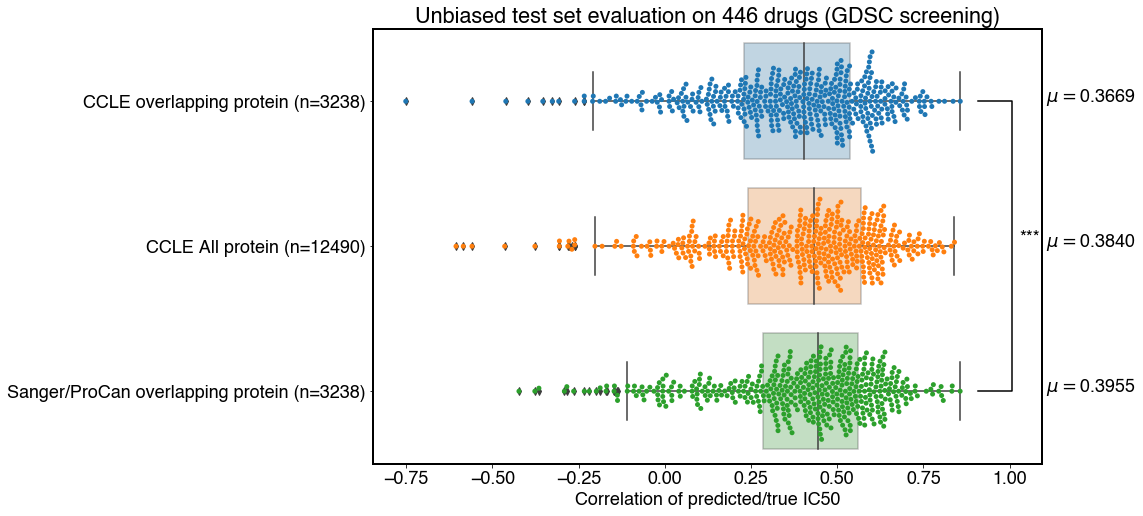

In [210]:
tmp_data = pd.melt(test_corr_df[[
    'Drug Id', 'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]],
                   id_vars='Drug Id',
                   value_vars=[
                       'CCLE overlapping protein', 'CCLE All protein',
                       'Sanger/ProCan overlapping protein'
                   ],
                   var_name='data_source',
                   value_name='Correlation')
fig = plt.figure(figsize=(12, 8))
ax = sns.boxplot('Correlation',
                 'data_source',
                 data=tmp_data,
                 orient='h',
                 boxprops=dict(alpha=.3))

y1, y2 = 0, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.1, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w + 0.05, (y1 + y2) * .5, "***", ha='center', va='bottom', color=col)

ax = sns.swarmplot('Correlation', 'data_source', data=tmp_data, orient='h')

ax.set_yticklabels(['CCLE overlapping protein (n=3238)', 'CCLE All protein (n=12490)',
                       'Sanger/ProCan overlapping protein (n=3238)'])
all_median = tmp_data.groupby(['data_source'])['Correlation'].median().sort_values()

all_mean = []
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].mean())
for i in range(len(all_median)):
    plt.text(tmp_data['Correlation'].max() + 0.25, i, r"$\mu=$"+f"{all_mean[i]:.4f}")
    
plt.xlabel("Correlation of predicted/true IC50")
plt.ylabel("")
plt.title("Unbiased test set evaluation on 446 drugs (GDSC screening)")
fig.patch.set_alpha(1)


In [12]:
ttest_rel(test_corr_df['CCLE overlapping protein'].values,
          test_corr_df['Sanger overlapping protein'].values)

Ttest_relResult(statistic=-4.34539747328248, pvalue=1.724050868891563e-05)

In [22]:
ttest_rel(test_corr_df['CCLE All protein'].values,
          test_corr_df['Sanger overlapping protein'].values)

Ttest_relResult(statistic=-1.8363891451620613, pvalue=0.06696700575136764)

In [22]:
pearsonr(np.nan_to_num(test_corr_df['CCLE overlapping protein'].values, nan=0),
          np.nan_to_num(test_corr_df['Sanger overlapping protein'].values, nan=0))[0]

0.8327375413860846

Text(0, 0.5, 'Sanger common proteins - drugs accuracy predicted/true correlation')

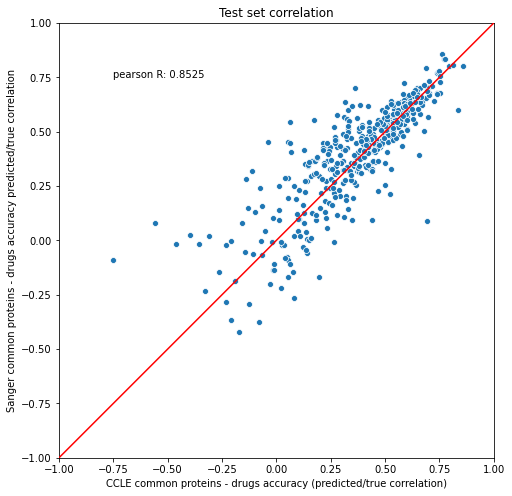

In [50]:
plt.figure(figsize=(12, 8))
r = spearmanr(
    np.nan_to_num(test_corr_df['CCLE overlapping protein'].values, nan=0),
    np.nan_to_num(test_corr_df['Sanger overlapping protein'].values, nan=0))[0]
g = sns.scatterplot(x='CCLE overlapping protein',
                    y='Sanger overlapping protein',
                    data=test_corr_df)
# g = sns.regplot('CCLE overlapping protein', 'Sanger overlapping protein', test_corr_df, line_kws={'color':'red'})
g.plot((-1, 1), (-1, 1), color='red', zorder=10)
g.set_xlim(-1, 1)
g.set_ylim(-1, 1)
g.set_aspect('equal')
g.text(-0.75, 0.75, f"pearson R: {r:0.4f}")
plt.title('Test set correlation')
plt.xlabel("CCLE common proteins - drugs accuracy (predicted/true correlation)")
plt.ylabel("Sanger common proteins - drugs accuracy predicted/true correlation")

In [36]:
sanger_score['test_corr'].mean()

0.31290131781175096

In [37]:
ccle_score['test_corr'].mean()

0.23331738424446505

## ccle drug

In [200]:
ccle_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091557_ccle_common_min_secondary_AUC.csv"
)
ccle_score_all = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091557_ccle_all_min_secondary_AUC.csv"
)
sanger_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091556_sanger_common_ruv_prism_min_secondary_AUC.csv"
)

In [175]:
ccle_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005090052_ccle_common_min_secondary_10.csv"
)
ccle_score_all = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005090052_ccle_all_min_secondary_10.csv"
)
sanger_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005090052_sanger_common_ruv_prism_min_secondary_10.csv"
)

In [194]:
ccle_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091549_ccle_common_min_secondary_IC50.csv"
)
ccle_score_all = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091549_ccle_all_min_secondary_IC50.csv"
)
sanger_score = pd.read_csv(
    "../work_dirs/vs_ccle_ccledrug/RandomForest/scores_202005091549_sanger_common_ruv_prism_min_secondary_IC50.csv"
)

In [201]:
test_corr_df = pd.merge(ccle_score[['Drug Id', 'test_corr']],
                        ccle_score_all[['Drug Id', 'test_corr']],
                        on=['Drug Id'],
                        suffixes=['_ccle_corr', '_ccle_all_corr'])

test_corr_df = pd.merge(test_corr_df,
                        sanger_score[['Drug Id', 'test_corr']],
                        on=['Drug Id'])
test_corr_df = test_corr_df.rename(
    columns={"test_corr": 'test_corr_sanger_corr'})
test_corr_df.columns = ['Drug Id',
    'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]

Text(0.5, 1.0, "Unbiased test set evaluation on 1389 drugs (Broad's screening)")

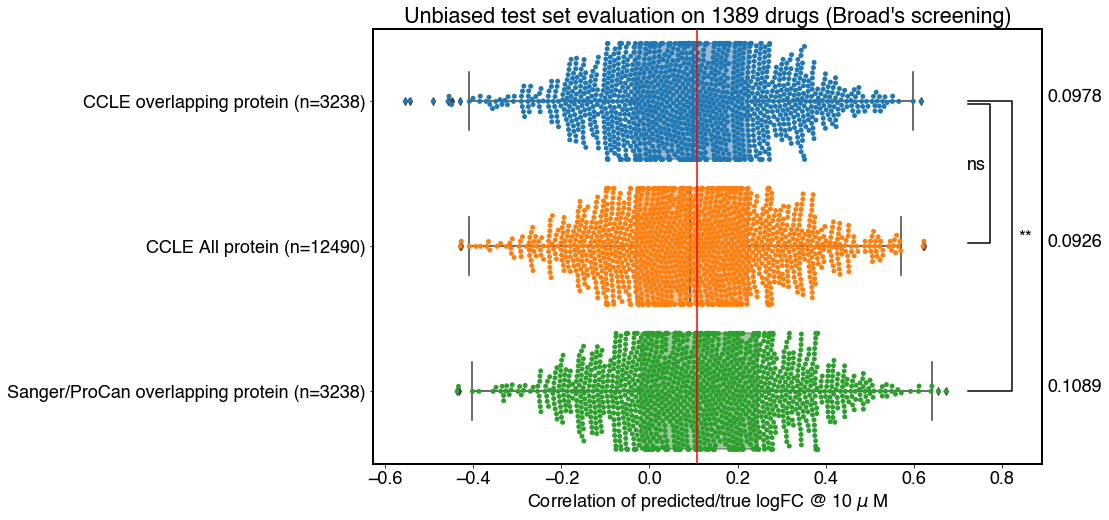

In [190]:
tmp_data = pd.melt(test_corr_df[[
    'Drug Id', 'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]],
                   id_vars='Drug Id',
                   value_vars=[
                       'CCLE overlapping protein', 'CCLE All protein',
                       'Sanger/ProCan overlapping protein'
                   ],
                   var_name='data_source',
                   value_name='Correlation')
plt.figure(figsize=(12, 8))
ax = sns.boxplot('Correlation',
                 'data_source',
                 data=tmp_data,
                 orient='h',
                 boxprops=dict(alpha=.5))
sns.swarmplot('Correlation', 'data_source', data=tmp_data, orient='h')
ax.set_yticklabels(['CCLE overlapping protein (n=3238)', 'CCLE All protein (n=12490)',
                       'Sanger/ProCan overlapping protein (n=3238)'])
x = tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median()
plt.plot([x, x], [-0.5, 2.5], color='red', zorder=10)

y1, y2 = 0, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.1, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w + 0.03, (y1 + y2) * .5, "**", ha='center', va='bottom', color=col)

y1, y2 = 0.02, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.05, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w - 0.03, (y1 + y2) * .5, "ns", ha='center', va='bottom', color=col)


all_median = []
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median())
all_mean = []
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].mean())
for i in range(len(all_median)):
    plt.text(tmp_data['Correlation'].max() + 0.23, i, f"{all_median[i]:.4f}")
plt.xlabel(r"Correlation of predicted/true logFC @ 10 $\mu$ M")
plt.ylabel("")
plt.title(f"Unbiased test set evaluation on {test_corr_df['Drug Id'].unique().size} drugs (Broad's screening)")

Text(0.5, 1.0, "Unbiased test set evaluation on 1389 drugs (Broad's screening)")

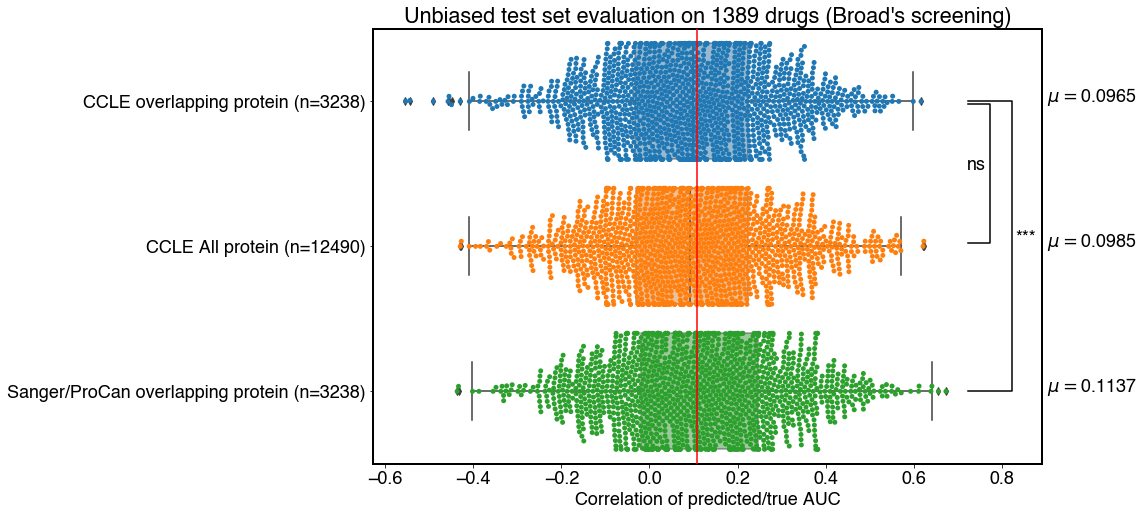

In [202]:
tmp_data = pd.melt(test_corr_df[[
    'Drug Id', 'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]],
                   id_vars='Drug Id',
                   value_vars=[
                       'CCLE overlapping protein', 'CCLE All protein',
                       'Sanger/ProCan overlapping protein'
                   ],
                   var_name='data_source',
                   value_name='Correlation')
plt.figure(figsize=(12, 8))
ax = sns.boxplot('Correlation',
                 'data_source',
                 data=tmp_data,
                 orient='h',
                 boxprops=dict(alpha=.5))
sns.swarmplot('Correlation', 'data_source', data=tmp_data, orient='h')
ax.set_yticklabels(['CCLE overlapping protein (n=3238)', 'CCLE All protein (n=12490)',
                       'Sanger/ProCan overlapping protein (n=3238)'])
x = tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median()
plt.plot([x, x], [-0.5, 2.5], color='red', zorder=10)

y1, y2 = 0, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.1, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w + 0.03, (y1 + y2) * .5, "***", ha='center', va='bottom', color=col)

y1, y2 = 0.02, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.05, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w - 0.03, (y1 + y2) * .5, "ns", ha='center', va='bottom', color=col)


all_median = []
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median())
all_mean = []
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].mean())
for i in range(len(all_median)):
    plt.text(tmp_data['Correlation'].max() + 0.23, i, r"$\mu=$"+f"{all_mean[i]:.4f}")
plt.xlabel(r"Correlation of predicted/true AUC")
plt.ylabel("")
plt.title(f"Unbiased test set evaluation on {test_corr_df['Drug Id'].unique().size} drugs (Broad's screening)")

Text(0.5, 1.0, "Unbiased test set evaluation on 330 drugs (Broad's screening)")

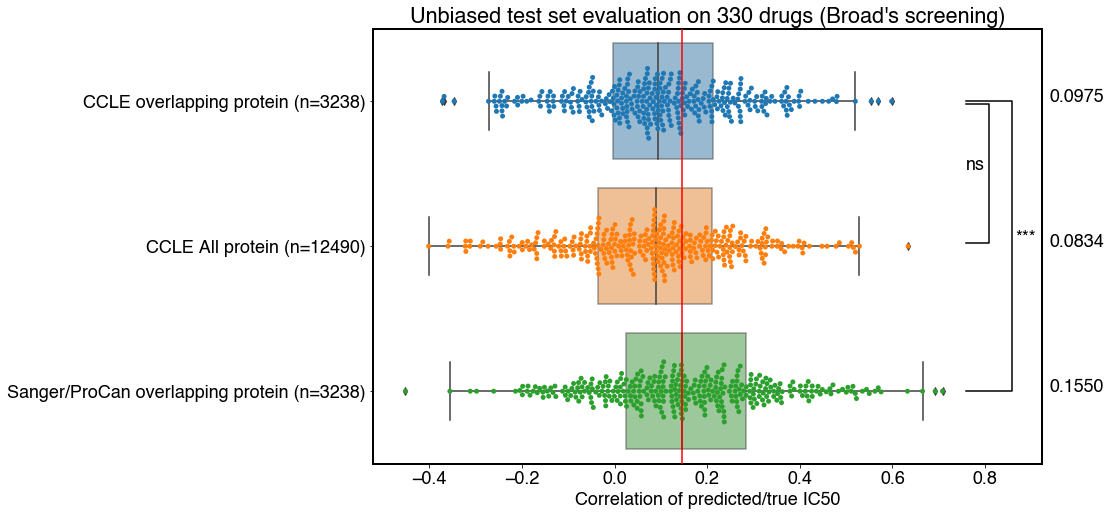

In [196]:
tmp_data = pd.melt(test_corr_df[[
    'Drug Id', 'CCLE overlapping protein', 'CCLE All protein',
    'Sanger/ProCan overlapping protein'
]],
                   id_vars='Drug Id',
                   value_vars=[
                       'CCLE overlapping protein', 'CCLE All protein',
                       'Sanger/ProCan overlapping protein'
                   ],
                   var_name='data_source',
                   value_name='Correlation')
plt.figure(figsize=(12, 8))
ax = sns.boxplot('Correlation',
                 'data_source',
                 data=tmp_data,
                 orient='h',
                 boxprops=dict(alpha=.5))
sns.swarmplot('Correlation', 'data_source', data=tmp_data, orient='h')
ax.set_yticklabels(['CCLE overlapping protein (n=3238)', 'CCLE All protein (n=12490)',
                       'Sanger/ProCan overlapping protein (n=3238)'])
x = tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median()
plt.plot([x, x], [-0.5, 2.5], color='red', zorder=10)

y1, y2 = 0, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.1, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w + 0.03, (y1 + y2) * .5, "***", ha='center', va='bottom', color=col)

y1, y2 = 0.02, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
x, w, col = tmp_data['Correlation'].max() + 0.05, 0.05, 'k'
plt.plot([x, x + w, x + w, x], [y1, y1, y2, y2], lw=1.5, c=col)
plt.text(x + w - 0.03, (y1 + y2) * .5, "ns", ha='center', va='bottom', color=col)

all_median = []
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].median())
all_median.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].median())
all_mean = []
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE overlapping protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'CCLE All protein']['Correlation'].mean())
all_mean.append(tmp_data[tmp_data['data_source'] ==
             'Sanger/ProCan overlapping protein']['Correlation'].mean())
for i in range(len(all_median)):
    plt.text(tmp_data['Correlation'].max() + 0.23, i, r"$\mu=$"+f"{all_mean[i]:.4f}")
plt.xlabel("Correlation of predicted/true IC50")
plt.ylabel("")
plt.title(f"Unbiased test set evaluation on {test_corr_df['Drug Id'].unique().size} drugs (Broad's screening)")

In [184]:
ttest_rel(test_corr_df['CCLE overlapping protein'].values,
          test_corr_df['Sanger/ProCan overlapping protein'].values)

Ttest_relResult(statistic=2.886532765105808, pvalue=0.0039579556508149635)

In [185]:
ttest_rel(test_corr_df['CCLE All protein'].values,
          test_corr_df['Sanger/ProCan overlapping protein'].values)

Ttest_relResult(statistic=1.3625372389244819, pvalue=0.17325872584300808)

In [186]:
ttest_rel(test_corr_df['CCLE overlapping protein'].values,
          test_corr_df['CCLE All protein'].values)

Ttest_relResult(statistic=0.884905683287066, pvalue=0.3763672099055927)

In [68]:
pearsonr(np.nan_to_num(test_corr_df['CCLE overlapping protein'].values, nan=0),
          np.nan_to_num(test_corr_df['Sanger overlapping protein'].values, nan=0))[0]

0.28687782114319815

Text(0, 0.5, 'Sanger common proteins - drugs accuracy predicted/true correlation')

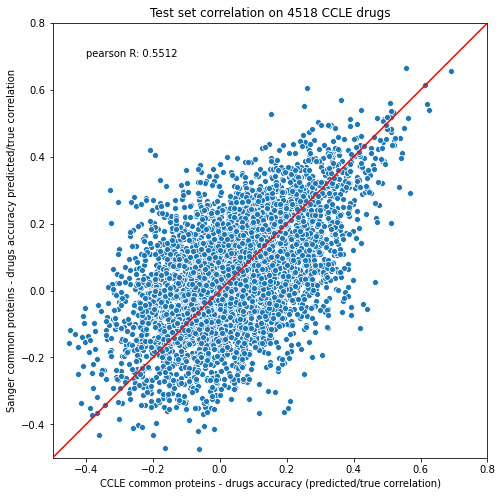

In [17]:
plt.figure(figsize=(12, 8))
r = pearsonr(
    np.nan_to_num(test_corr_df['CCLE overlapping protein'].values, nan=0),
    np.nan_to_num(test_corr_df['Sanger overlapping protein'].values, nan=0))[0]
g = sns.scatterplot(x='CCLE overlapping protein',
                    y='Sanger overlapping protein',
                    data=test_corr_df)
# g = sns.regplot('CCLE overlapping protein', 'Sanger overlapping protein', test_corr_df, line_kws={'color':'red'})
g.plot((-.5, .8), (-.5, .8), color='red', zorder=10)
g.set_xlim(-.5, .8)
g.set_ylim(-.5, .8)
g.set_aspect('equal')
g.text(-0.4, 0.7, f"pearson R: {r:0.4f}")
plt.title('Test set correlation on 4518 CCLE drugs')
plt.xlabel("CCLE common proteins - drugs accuracy (predicted/true correlation)")
plt.ylabel("Sanger common proteins - drugs accuracy predicted/true correlation")

# feature importance comparison

In [ ]:
sanger_feature = pd.read_csv("../work_dirs/vs_ccle_ccledrug/RandomForest/")

# CCLE correlate with RNA

In [ ]:
combined_noblood = combined[combined['Tissue_type']!='Haematopoietic and Lymphoid']
combined_blood = combined[combined['Tissue_type']=='Haematopoietic and Lymphoid']

In [51]:
ccle_protein_common = ccle_protein[ccle_protein['Cell_line'].isin(common_cell_lines)].set_index(['Cell_line'])
ccle_protein_common = ccle_protein_common[common_proteins]
ccle_protein_common = ccle_protein_common.reset_index()
ccle_protein_common = ccle_protein_common.drop_duplicates(['Cell_line'])

In [52]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

In [53]:
name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [54]:
rna_raw = pd.read_csv("../data/rna/rnaseq_voom.csv", index_col=0).T

rna_raw.index.name='SIDM'

rna_raw = rna_raw.reset_index()

In [55]:
rna_sample = pd.merge(rna_raw,
                      meta[['SIDM',
                            'Cell_line']].drop_duplicates()).drop(['SIDM'],
                                                                  axis=1)

In [42]:
corr_dict = {}
gene_not_found = []
protein_not_found = []
for protein in ccle_protein_common.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(ccle_protein_common[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict[protein] = pearsonr(data.iloc[:, 1], data.iloc[:, 2])[0]


In [43]:
np.median(list(corr_dict.values()))

0.543877409264814

Text(-0.3472845380173486, 200, 'Median: 0.5439')

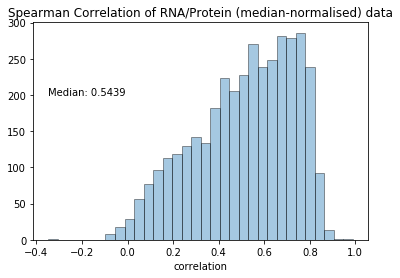

In [44]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Spearman Correlation of RNA/Protein (median-normalised) data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 200,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'EGFR_RNA')

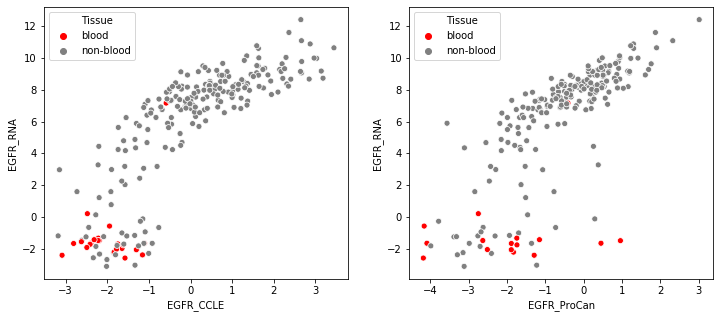

In [95]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ccle_egfr = ccle_protein_common[['Cell_line', 'EGFR_HUMAN']]
ccle_egfr['Tissue'] = ccle_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(ccle_egfr, rna_sample[['Cell_line', 'EGFR']])

sns.scatterplot(x='EGFR_HUMAN', y='EGFR', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[0])

sanger_egfr = sanger_protein_common[['Cell_line', 'EGFR_HUMAN']]
sanger_egfr['Tissue'] = sanger_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(sanger_egfr, rna_sample[['Cell_line', 'EGFR']])

sns.scatterplot(x='EGFR_HUMAN', y='EGFR', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[1])

ax[0].set_xlabel("EGFR_CCLE")
ax[0].set_ylabel("EGFR_RNA")
ax[1].set_xlabel("EGFR_ProCan")
ax[1].set_ylabel("EGFR_RNA")

/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/scai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'MET_RNA')

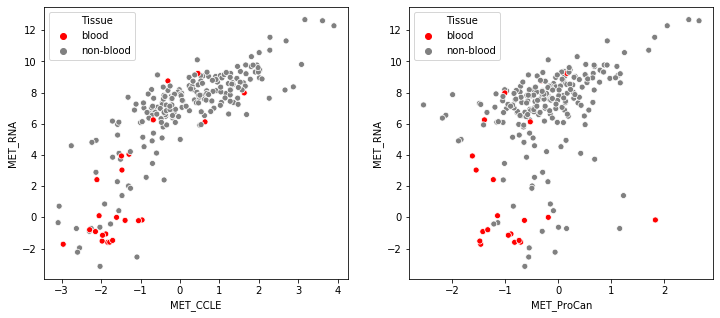

In [96]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ccle_egfr = ccle_protein_common[['Cell_line', 'MET_HUMAN']]
ccle_egfr['Tissue'] = ccle_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(ccle_egfr, rna_sample[['Cell_line', 'MET']])

sns.scatterplot(x='MET_HUMAN', y='MET', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[0])

sanger_egfr = sanger_protein_common[['Cell_line', 'MET_HUMAN']]
sanger_egfr['Tissue'] = sanger_egfr['Cell_line'].map(
    lambda x: 'blood' if x in combined_blood['Cell_line'].values else 'non-blood')

combined_egfr = pd.merge(sanger_egfr, rna_sample[['Cell_line', 'MET']])

sns.scatterplot(x='MET_HUMAN', y='MET', hue='Tissue', data=combined_egfr, palette=['red', 'grey'],ax=ax[1])

ax[0].set_xlabel("MET_CCLE")
ax[0].set_ylabel("MET_RNA")
ax[1].set_xlabel("MET_ProCan")
ax[1].set_ylabel("MET_RNA")